In [425]:
using Plots
using ForwardDiff
using ProgressMeter

In [426]:
function sample!(x,θ)
    T = size(θ,2) + 1
    for t = 1:T-1
        x[t+1] = x[t] + ( rand() < θ[x[t] + T, t] ? 1 : -1 )
    end
end

sample! (generic function with 1 method)

In [428]:
function logqt(x,θt,t)
    return log((x[t+1] - x[t]) == 1 ? θt[x[t] + T] : 1 - θt[x[t] + T])
end

function logQ(x,θ)
    T = size(θ,2) + 1
    s = 0
    for t = 1:T-1
        s += logqt(x,θ[:,t],t) 
    end
    return s
end

function isok(x)
    return   8 <= abs.(x[end]) <= 35
end

function logO(x,window)
    if  window[1] <= (x[end]) <= window[2]
        return 0
    elseif x[end] < window[1]
        return - (x[end] - window[1])^8 - 10
    elseif x[end] > window[2]
        return - abs(x[end] - window[2])^8 - 10
    end
end


function logO(x,window)
    if  window[1] <= abs.(x[end]) <= window[2]
        return 0
    else 
        return -15
    end
end

logO (generic function with 1 method)

In [429]:
function gradient!(dθ, x, θ)
    T = size(θ,2) + 1
    for t = 1:T-1
        ForwardDiff.gradient!((@view dθ[:,t]), θt -> logqt(x,θt,t), θ[:,t])
    end
end

gradient! (generic function with 1 method)

In [430]:
function descend!(θ, θp, θmin, θmax, window; numsamples=10^4, numiters=100, η=0.1)
    N = size(θ,1)
    T = size(θ,2) + 1
    dθ = zero(θ)
    x = zeros(Int, T)
    pr = Progress(numiters) 
    avF = 0
    for it = 1:numiters
        avF = 0
        Dθ = zero(θ)
        for s = 1:numsamples
            sample!(x, θ)
            F = logQ(x,θ) - logQ(x,θp) - logO(x,window)
            avF += F / numsamples
            gradient!(dθ, x, θ)
            Dθ .+= F .* dθ ./ numsamples
        end
        θ .-= sign.(Dθ) .* η
        θ .= clamp.(θ, θmin, θmax)
        ProgressMeter.next!(pr, showvalues=[(:F,sum(avF))])
    end
    return avF
end

descend! (generic function with 1 method)

In [446]:
T = 40 #total time of movement
N = 2T - 1

θ = fill(1/2,N,T-1); 
#This is an N x T matrix where θ[i,t] represents 
#the probability of jumping to right at time t for particle i
#The prob of jumping to left is 1-θ[i,t]
dθ = fill(1/2,N,T-1); 

θp = fill(1/2,N,T-1); 

x = zeros(Int,T);

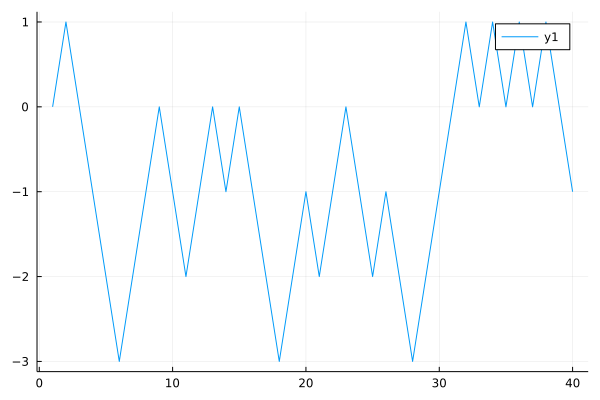

In [447]:
sample!(x,θp)
plot(x)

In [448]:
window = [5 15]
avF = descend!(θ, θp, 1e-4, 1-1e-4, window; numsamples=5000, numiters=40, η=0.03)
avF = descend!(θ, θp, 1e-4, 1-1e-4, window; numsamples=5000, numiters=40, η=0.01)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/students/mmariani/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00
  F:  0.7160951625070285


0.7160951625070285

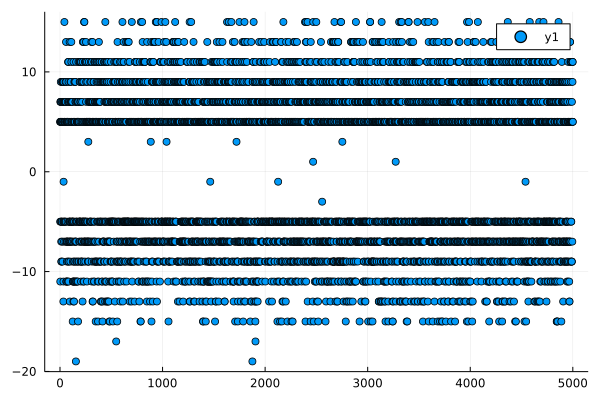

In [449]:
final_pt = zeros(5000)
p_sptime = zeros(N,T)
for st = 1:5000
    sample!(x,θ)
    for t in 1:T
        p_sptime[x[t] + T,t] += 1
    end
    final_pt[st] = x[end]
end
scatter(final_pt)
#savefig("final_points.pdf")

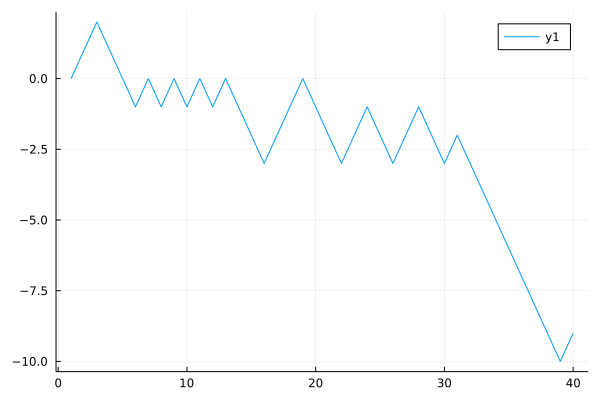

In [450]:
sample!(x,θ)
plot(x)

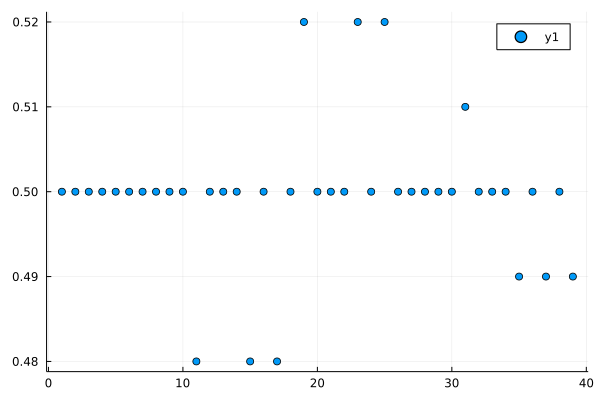

In [451]:
i = -10
scatter(θ[i+T,:])
#scatter!(θ[85,:])

In [452]:
# probbiiltà di trovarsi a un punto a un tempo
#plot dei rate in base quante volte vengono utilizzati
# energia con false rate finto
# cono deterministico: provare a ottenerlo e sia proare a imporlo
#heatplot spazio y- tempo x - probabilità z

In [469]:
T = 40 #total time of movement
N = 2T - 1
heatmap(1:N,1:T,log.(p_sptime') .- 9)
savefig("heatmap.png")

# Exact solution

In [460]:
using LinearAlgebra, SparseArrays
A⊕B = kron(I(size(B,1)), A)+kron(B, I(size(A,1)))
lattice(n) = spdiagm(1=>trues(n-1),-1=>trues(n-1))
lattice(L...) = lattice(L[1])⊕lattice(L[2:end]...)
clattice(n) = (A=lattice(n); A[1,end]=A[end,1]=true; A)
clattice(L...) = clattice(L[1])⊕clattice(L[2:end]...)

clattice (generic function with 2 methods)

In [461]:
N = 2T
i0 = N÷2
R = Set(T - window[2] : T - window[1]) ∪ Set(T + window[1] : T + window[2])
A = 1.0*lattice(N);
A ./= sum(A, dims=1);
#T = 40
#t = 3

In [462]:
function marginal(i0,t,R,T)
    A1 = A^t
    A2 = A^(T-t)
    A3 = A^T
    [sum(A2[j,i] for i∈R) * A1[i0, j] / sum(A3[i0, i] for i∈R) for j=1:N]
end

marginal (generic function with 1 method)

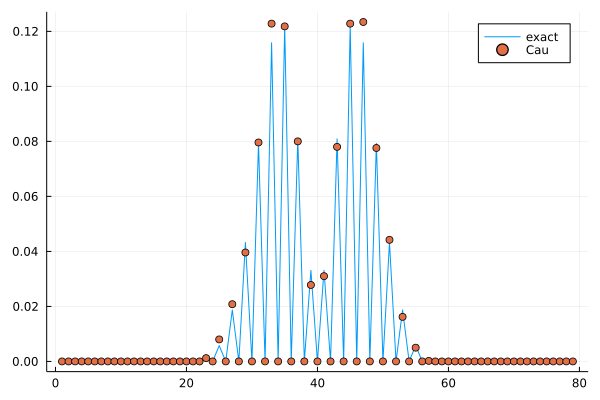

In [472]:
t = 33
plot(marginal(i0,t,R,T-1),label="exact")
scatter!(p_sptime[: ,t+1] ./ sum(p_sptime[: ,t+1]),label = "Cau")
#savefig("tomi.png")